# 1. Import thư viện


In [150]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import random
import matplotlib.pyplot as plt

#2. Lấy dữ liệu 

In [151]:
train = pd.read_csv('/content/train_record.csv')
test = pd.read_csv('/content/test_record.csv')

In [152]:
train.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [153]:
train.shape

(248, 13)

In [154]:
train.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [155]:
train.duplicated().sum()

0

In [156]:
train.corr(method='pearson', min_periods=1).style.background_gradient()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
age,1.000000,0.044053,-0.110982,-0.102228,0.096577,0.109473,-0.050698,0.155854,0.009323,0.045205,-0.021358,-0.257270,0.280419
anaemia,0.044053,1.000000,-0.177491,-0.014501,0.100935,0.001667,-0.036416,0.056259,0.069163,-0.099311,-0.093717,-0.154169,0.039969
creatinine_phosphokinase,-0.110982,-0.177491,1.000000,-0.053534,-0.059352,-0.099699,0.000549,-0.088125,0.065308,0.078602,0.001783,-0.001148,-0.009229
diabetes,-0.102228,-0.014501,-0.053534,1.000000,0.000933,-0.044221,0.100455,-0.064708,-0.096201,-0.173835,-0.158608,0.024918,0.009280
ejection_fraction,0.096577,0.100935,-0.059352,0.000933,1.000000,0.056360,0.084977,-0.014439,0.179712,-0.132707,-0.054787,0.021501,-0.175601
high_blood_pressure,0.109473,0.001667,-0.099699,-0.044221,0.056360,1.000000,0.057154,0.020122,0.031427,-0.116622,-0.007695,-0.210591,0.105355
platelets,-0.050698,-0.036416,0.000549,0.100455,0.084977,0.057154,1.000000,-0.016501,0.040489,-0.116494,0.072916,0.028824,-0.091836
serum_creatinine,0.155854,0.056259,-0.088125,-0.064708,-0.014439,0.020122,-0.016501,1.000000,-0.207186,0.040677,-0.005628,-0.157321,0.286607
serum_sodium,0.009323,0.069163,0.065308,-0.096201,0.179712,0.031427,0.040489,-0.207186,1.000000,-0.015161,0.037993,0.123418,-0.210959
sex,0.045205,-0.099311,0.078602,-0.173835,-0.132707,-0.116622,-0.116494,0.040677,-0.015161,1.000000,0.461537,-0.022844,0.023419


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) a

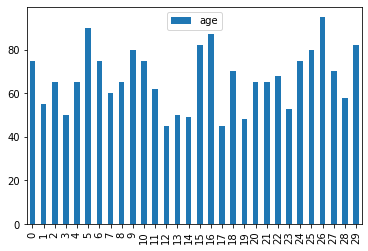

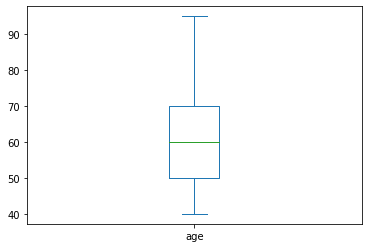

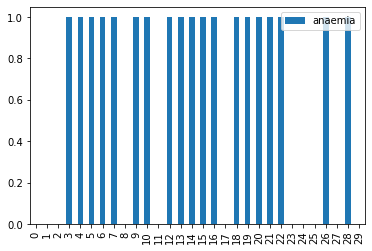

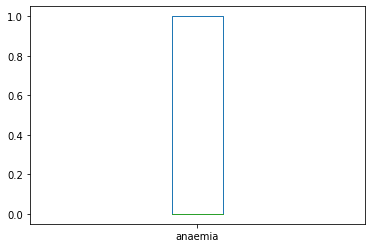

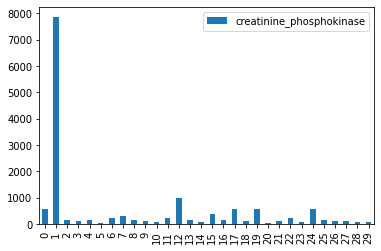

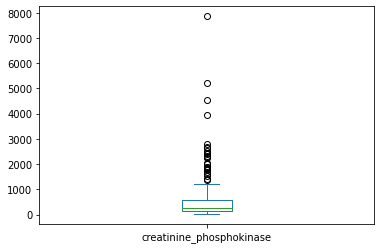

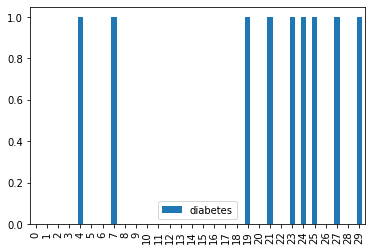

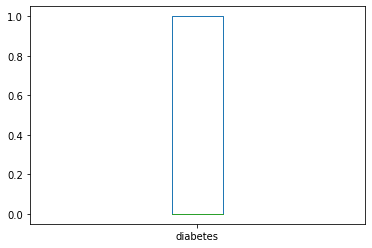

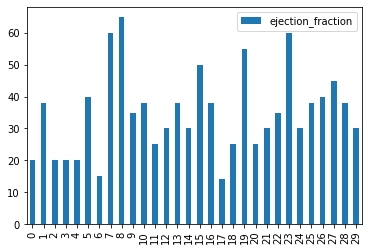

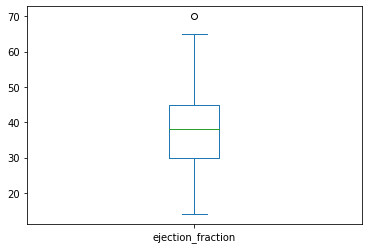

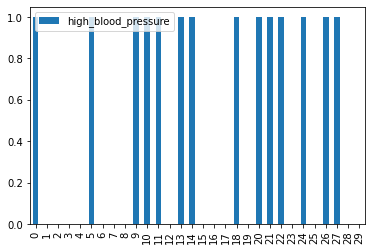

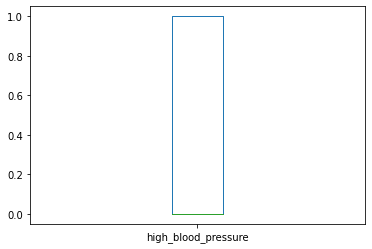

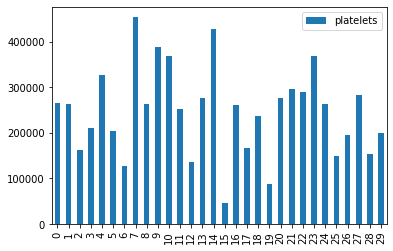

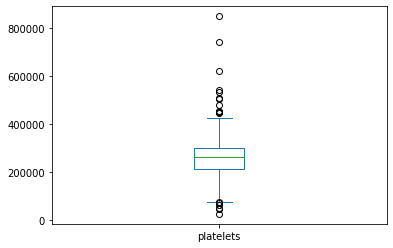

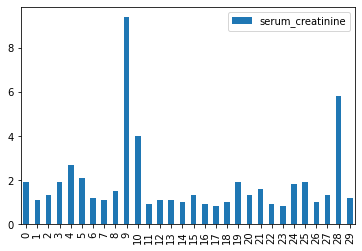

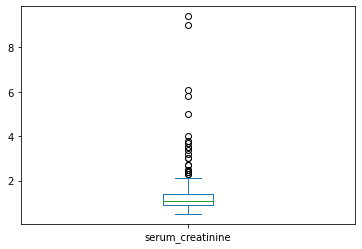

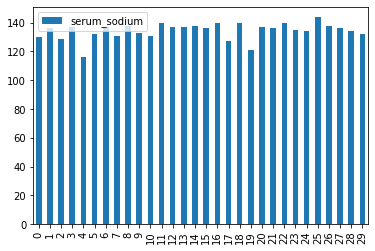

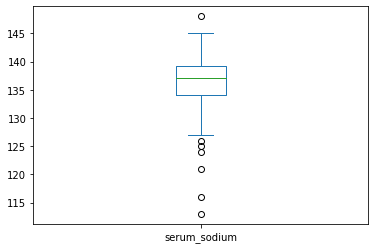

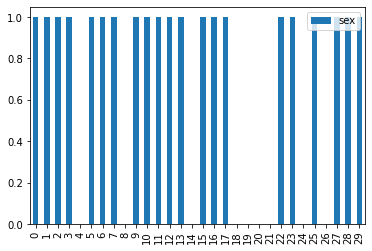

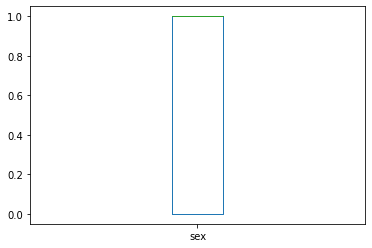

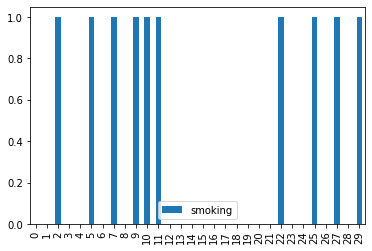

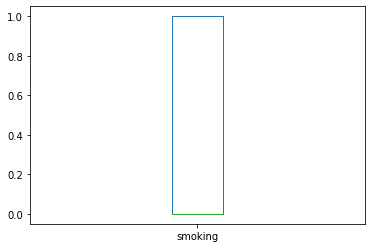

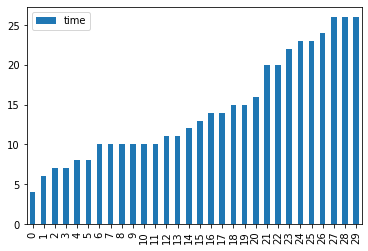

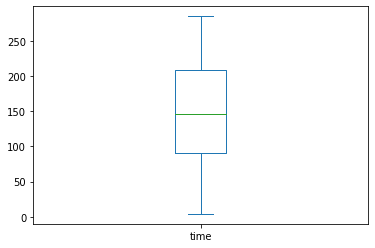

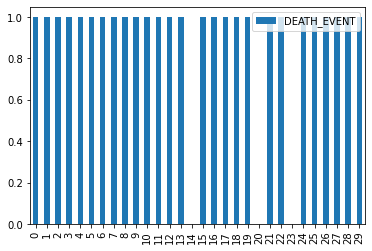

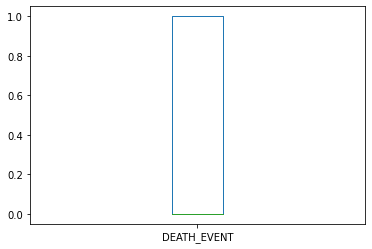

In [157]:
for x,y in enumerate(train):
  train[:30].plot(kind = 'bar' , y = y)
  train.plot.box(y=y)

In [158]:
def normalize(X):
  mu = np.mean(X, axis = 0)
  sigma = np.std(X, axis = 0)
  X = (X - mu)/sigma
  return X
train['creatinine_phosphokinase'] = normalize(np.array(train['creatinine_phosphokinase']))
train['platelets'] = normalize(np.array(train['platelets']))
test['creatinine_phosphokinase'] = normalize(np.array(test['creatinine_phosphokinase']))
test['platelets'] = normalize(np.array(test['platelets']))
X_train = np.array(train.drop(columns = 'DEATH_EVENT'))
y_train = np.array(train['DEATH_EVENT'])
X_test = np.array(test.drop(columns = 'DEATH_EVENT'))
y_test = np.array(test['DEATH_EVENT'])

In [159]:
class Network:
  def __init__(self, X,y,epoch = 4000):
    self.epoch = epoch
    self.learning_rate = 0
    self.input_layer = 12
    self.hidden_layer = 30
    self.X = X
    self.y = y

  def one_hot_y(self,y):
    mapped_y = np.zeros([len(self.y), 2])
    for i in range(len(self.y)):
      if self.y[i] == 1:
        mapped_y[i] = [0,1]
      else:
        mapped_y[i]= [1,0]
    return mapped_y
    
  def initialize_weights(self,input_layer, hidden_layer):
    __epsilon = 0.12
    self.w1 = np.zeros((self.input_layer + 1,self.hidden_layer))
    self.w2 = np.zeros((self.hidden_layer + 1,2))
    self.w1 = np.random.rand(self.input_layer+1,self.hidden_layer)*(2*__epsilon) - __epsilon
    self.w2 = np.random.rand(self.hidden_layer+1, 2)*(2*__epsilon) - __epsilon
    return self.w1,self.w2

  def sigmoid(self,X):
    return 1/(1+np.exp(-X))
  def relu(self,X):
    for i in range(X.shape[0]):
      for j in range(X.shape[1]):
        if X[i][j] < 0 :
          X[i][j] = 0
    return X

  def add_bias(self,m,X):
    bias = np.ones((m,1))
    X = np.append(bias, X, axis=1)
    return X

  def forward(self,w, X):
    z = X.dot(w.T)
    f = self.sigmoid(z)
    return f
  def forward1(self,w,X):
    z = X.dot(w.T)
    f = self.relu(z)
    return f
  def compute_cost(self,param,X,y,input_layer,hidden_layer):
    m,n = self.X.shape
    cost = 0
    w1 = param[:(self.input_layer+1)*self.hidden_layer].reshape(self.input_layer+1,self.hidden_layer)
    w2 = param[(self.input_layer+1)*self.hidden_layer:].reshape(self.hidden_layer+1,2)  
    X1 = self.add_bias(m,self.X)
    layer2 = self.add_bias(m, self.forward1(w1.T,X1))
    y_pre = self.forward(w2.T,layer2)
    cost = (1/m)*np.sum((-(y*np.log(y_pre)))-((1-y)*np.log(1-y_pre)))
    return cost 
  def sigmoid_gradient(self, z):
    return z*(1-z)
  def sigmoid_relu(self, z):
    for i in range(z.shape[0]):
      for j in range(z.shape[1]):
        if z[i][j] <= 0:
          z[i][j] = 0
        else:
          z[i][j] = 1
    return z
  
  def backpro_gradient(self,w1,w2,X,y,learning_rate):
    m,n = self.X.shape
    X1 = self.add_bias(m, self.X)    #248,13
    layer2_noadd = self.forward1(self.w1.T,X1)    #248,7
    layer2 = self.add_bias(m,layer2_noadd)   #248,8
    y_pre = self.forward(self.w2.T,layer2)      #248,2
    E1 = y - y_pre                    #248,2
    t2_grad = E1*self.sigmoid_gradient(y_pre)  #248,2
    E2 = (t2_grad.dot((self.w2.T)[:,1:]))       #248,7
    t1_grad = E2*self.sigmoid_relu(layer2_noadd)   #248,7
    self.w1 += self.learning_rate*(X1.T.dot(t1_grad))      #13,7
    self.w2 += self.learning_rate*(layer2.T.dot(t2_grad)) #8,2
    return self.w1, self.w2
  
  def get_learning_rate(self, epoch):
    if self.epoch < 10:
      learning_rate = 0.01
    if 10 <= self.epoch < 20:
      learning_rate = 0.001
    if 20 <= self.epoch < 50:
      learning_rate = 0.0001
    if  self.epoch >= 100:
      learning_rate = 0.00001
    return learning_rate

  def Train(self):
    self.loss = []
    self.acc = []
    y = self.one_hot_y(self.y)
    np.random.seed(42)
    self.w1, self.w2 = self.initialize_weights(self.input_layer,self.hidden_layer)
    for i in range(self.epoch):
      m,n = self.X.shape
      self.learning_rate = self.get_learning_rate(i)
      self.w1 , self.w2 = self.backpro_gradient(self.w1, self.w2, self.X, y, self.learning_rate)
      param = np.concatenate([self.w1.flatten(), self.w2.flatten()])
      J = self.compute_cost(param,self.X,y,self.input_layer,self.hidden_layer)
      X1 = self.add_bias(m,self.X)
      layer2 = self.add_bias(m,self.forward1(self.w1.T,X1))
      predictions = self.forward(self.w2.T,layer2)
      accuracy = np.mean(np.argmax(predictions, axis = 1) == self.y) * 100
      self.loss.append([J])
      self.acc.append([accuracy])
      print(f'epoch = {i}----------',f'Loss = {J} ---------' ,f'accuracy = {accuracy}')
    return self.w1 ,self.w2
  
  def Test(self,w1,w2,X,y):
    m = len(X)
    X_test1 = self.add_bias(m,X)
    layer_2 = self.add_bias(m,self.forward1(w1.T,X_test1))
    predictions = self.forward(w2.T,layer_2)
    accuracy_test = np.mean(np.argmax(predictions, axis = 1) == y) * 100
    print('accuracy_test = ',accuracy_test)
    return None
  
  def plot(self):
    epoch = list(range(0, self.epoch, 1))
    plt.subplot(1,2,1)
    plt.plot(epoch,self.loss)
    plt.title('Loss_train')
    plt.ylabel("Loss")
    plt.xlabel("epoch")
    plt.subplot(1,2,2)
    plt.plot(epoch,self.acc)
    plt.title('Accuracy_train')
    plt.ylabel("Accuracy")
    plt.xlabel("epoch")
    return None

In [160]:
network = Network(X_train,y_train,3000)
w1,w2 = network.Train()

epoch = 0---------- Loss = 8.58829103185933 --------- accuracy = 29.03225806451613
epoch = 1---------- Loss = 8.46248315698439 --------- accuracy = 29.03225806451613
epoch = 2---------- Loss = 8.31918177500815 --------- accuracy = 29.03225806451613
epoch = 3---------- Loss = 8.152546854937322 --------- accuracy = 29.03225806451613
epoch = 4---------- Loss = 7.953568526329485 --------- accuracy = 29.03225806451613
epoch = 5---------- Loss = 7.706633086172426 --------- accuracy = 29.03225806451613
epoch = 6---------- Loss = 7.384018891626059 --------- accuracy = 29.03225806451613
epoch = 7---------- Loss = 6.932281414907168 --------- accuracy = 29.03225806451613
epoch = 8---------- Loss = 6.265522892461578 --------- accuracy = 29.03225806451613
epoch = 9---------- Loss = 5.471067977256478 --------- accuracy = 29.03225806451613
epoch = 10---------- Loss = 5.106815302923879 --------- accuracy = 29.03225806451613
epoch = 11---------- Loss = 4.943212755003748 --------- accuracy = 29.03225806

In [161]:
network.Test(w1,w2,X_test,y_test)

accuracy_test =  80.3921568627451


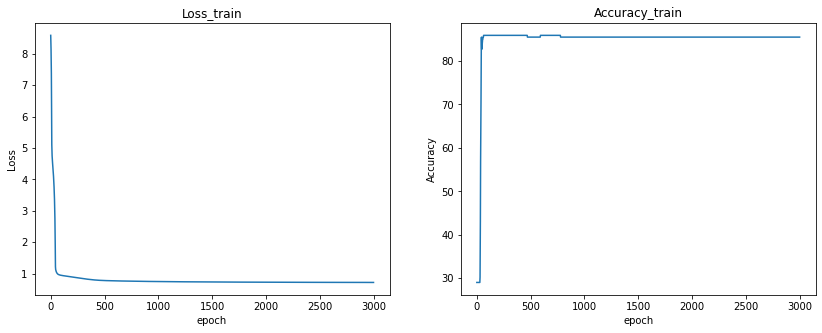

In [162]:
from matplotlib.pyplot import figure
figure(figsize=(14, 5))
network.plot()